# Human Pose Estimation - Part 1

## SVHN Dataset

--2020-03-12 14:02:37--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat.3’

train_32x32.mat.3   100%[===================>] 173.61M  20.4MB/s    in 11s     

2020-03-12 14:02:49 (15.5 MB/s) - ‘train_32x32.mat.3’ saved [182040794/182040794]

--2020-03-12 14:02:50--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat.3’

test_32x32.mat.3    100%[===================>]  61.30M  15.8MB/s    in 5.7s    

2020-03-12 14:02:56 (10.7 MB/s) - ‘test_32x32.mat.3’ saved [642

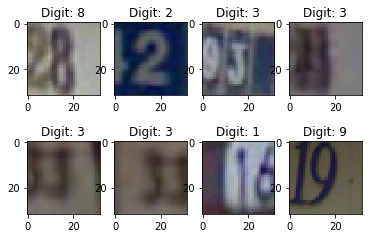

In [23]:
# initialization
%matplotlib inline
import numpy as np
from PIL import Image
from scipy.io import loadmat
from matplotlib.pyplot import imshow, show, subplots

# download the train and teset datasets
!wget http://ufldl.stanford.edu/housenumbers/train_32x32.mat
!wget http://ufldl.stanford.edu/housenumbers/test_32x32.mat
  
# Load the training data
train = loadmat('train_32x32.mat')
print("Training images dimensions: ", train['X'].shape) # Input Data
print("Training labels dimensions: ", train['y'].shape) # Labels

test = loadmat('test_32x32.mat')
print("Test images dimensions: ", test['X'].shape)
print("Test labels dimensions: ", test['y'].shape)

# replace label 10 with label
test['y'][test['y']==10] = 0
train['y'][train['y']==10] = 0

# Sample a random images. It may look like there are multiple digits, but the label corresponds to the centered digit within each image
num_samples = 8
train_size = train['X'].shape[0]

indices = np.random.choice(train_size, num_samples)
fig, axes = subplots(2,4)
for i, ax in zip(indices, axes.flat):
    im = train['X'][:,:,:,i]
    label = train['y'][i]

    ax.imshow(np.asarray(im))
    ax.set_title("Digit: {}".format(label[0]))

show()

## COCO Dataset

In [ ]:
# This code downloads the coco dataset from Amazon S3 in parallel.
import boto3
from botocore import UNSIGNED
from botocore.client import Config
import multiprocessing
import subprocess
files = ['val2017.zip', 'annotations_trainval2017.zip'] # For Part 1, you won't need the train2017.zip

s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
def download_and_unzip_from_s3(file_name, bucket_name='fast-ai-coco'):
    print("Downloading", file_name)
    s3.download_file(bucket_name, file_name, file_name)
    print("Finished downloading", file_name, ". Starting to unzip.")
    subprocess.run(["unzip", file_name])
    print("Finished unzipping", file_name)

# Download in parallel
num_cpus = multiprocessing.cpu_count()
with multiprocessing.Pool(num_cpus) as p:
    p.map(download_and_unzip_from_s3, files)

print("Done transferring all datasets")

Finished downloading annotations_trainval2017.zip . Starting to unzip.
Finished downloading val2017.zip . Starting to unzip.
Finished unzipping val2017.zip
Finished unzipping annotations_trainval2017.zip
Done transferring all datasets


In [ ]:
# read annotation json file
import json
from pprint import pprint

keypoints_filename = 'annotations/person_keypoints_val2017.json'
json_file =  open(keypoints_filename)
kp_dataset = json.load(json_file)

# get sample annotation
kp_data = kp_dataset['annotations'][0]

# get 17 keypoint names
kp_categories = kp_dataset['categories'][0]['keypoints']
pprint(kp_categories)

['nose',
 'left_eye',
 'right_eye',
 'left_ear',
 'right_ear',
 'left_shoulder',
 'right_shoulder',
 'left_elbow',
 'right_elbow',
 'left_wrist',
 'right_wrist',
 'left_hip',
 'right_hip',
 'left_knee',
 'right_knee',
 'left_ankle',
 'right_ankle']


In [ ]:
# Extract the keypoints as (x,y,v) tuples. There should be 17 tuples. 
# arrange keypoints as tuple
keypoints_list = np.asarray(kp_data['keypoints'])
  
# keypoints have 3 columns, x,y,v
keypoints_3d = np.reshape(keypoints_list,(17,3))
keypoints = keypoints_3d[:,:2]

# check if keypoints are valid 
# V==(0: does not exist, 1:not visible, 2: visible)
gt_validity = keypoints_3d[:,2]>0

In [ ]:
# crop person and rescale to input image size
input_width=192
input_height=256

# image loading, cropping and resizing
def crop_and_resize_image(annotations, base_path = './val2017', height=256, width=192):

    # Parse the annotations
    x_start, y_start, box_w, box_h = annotations['bbox']
    img_id = str(annotations['image_id'])

    # Open to Image
    img_name = '000000000000'
    img_name = img_name[0:len(img_name) - len(img_id)] + img_id
    orig_img = Image.open(base_path + '/' + img_name + '.jpg')

    # Rescale Input Image
    img_w, img_h = orig_img.size
    rescaled_img = orig_img.resize((width,height), box=(x_start, y_start, x_start+box_w, y_start+box_h))
    
    print ("original image size:", img_w, img_h)
    print ("resized image size:",rescaled_img.size)
    print ("Box size:     ", box_w, box_h)
    print ("Box location: ", x_start,y_start)
    
    return orig_img, rescaled_img
img_orig, img_rescaled = crop_and_resize_image(kp_data,height=input_height,width=input_width)

# rescale keypoints to match new image size
x_start, y_start, box_w, box_h = kp_data['bbox']
box_offset = np.asarray([x_start,y_start])
box_dims = np.asarray([box_w,box_h])
input_dims = np.asarray([input_width,input_height])
keypoints = np.round((keypoints - box_offset) * input_dims / box_dims).astype(int)

original image size: 480 640
resized image size: (192, 256)
Box size:      300.58 372.5
Box location:  73.35 206.02


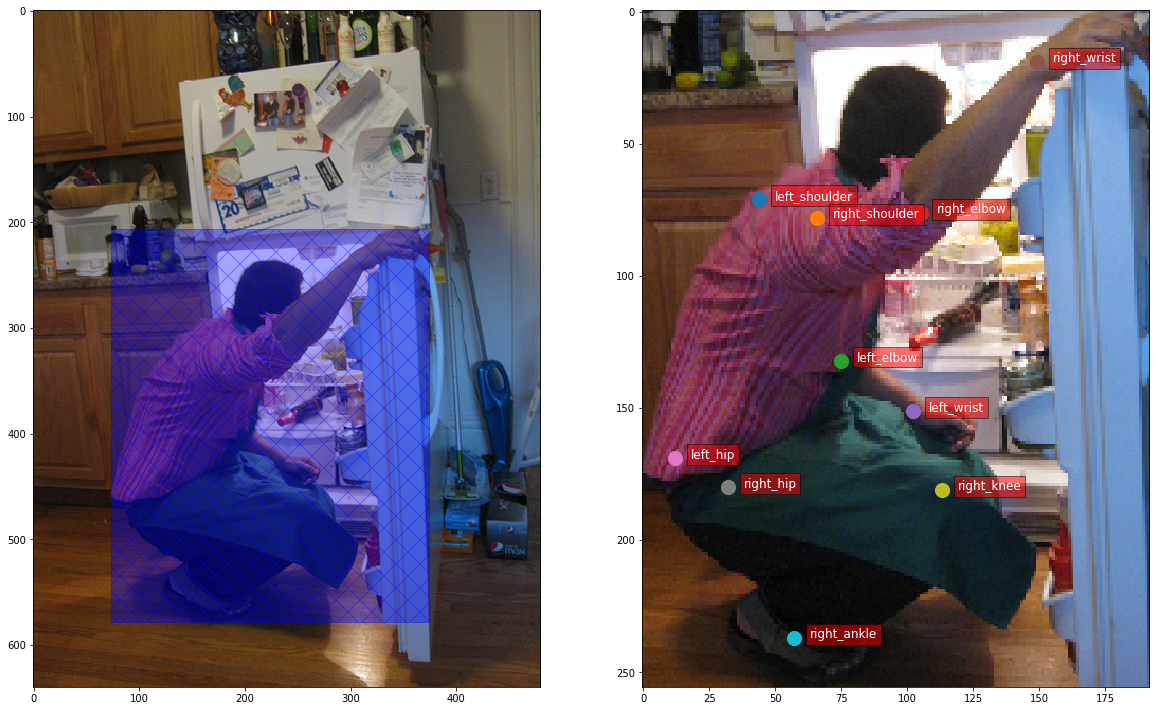

In [ ]:
# plot coco image
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
# plot keypoints on image
def plot_keypoints(keypoints,keypoint_scores,keypoint_names,ax):
    score_threshold = 0.5
  
    for j in range(len(keypoint_names)):
        n = keypoint_names[j]
        x = keypoints[j,0]
        y = keypoints[j,1]

        if keypoint_scores[j]>score_threshold:
          ax.scatter(x, y, 200)
          ax.text(x+6, y, n, fontsize=12,bbox=dict(facecolor='red', alpha=0.5),color='w')
      
# show original and resized image
fig = plt.figure(1,figsize=(20,20))
ax1 = fig.add_subplot(121)  # left side
ax1.imshow(img_orig)
ax1.add_patch(Rectangle((x_start, y_start), box_w, box_h, alpha=0.35, facecolor="blue", edgecolor="blue", hatch='x'))

ax2 = fig.add_subplot(122)  # right side
ax2.imshow(img_rescaled)
ax2 = plot_keypoints(keypoints,gt_validity,kp_categories,ax2)
plt.show()